In [1]:
pip install pyTsetlinMachine

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install PyTsetlinMachineCUDA

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PyTsetlinMachineCUDA.tm import MultiClassTsetlinMachine
import PyTsetlinMachineCUDA.tm
import pyTsetlinMachine
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.signal import spectrogram
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import random
from scipy.ndimage import zoom
from sklearn.metrics import confusion_matrix
import json

In [ ]:
json_file = 'TM_CWRU_MTM_thermometer_avg.json' # Stores the result in here
directory_path = "../data/CWRU/Faulty" # Path to CWRU files

In [4]:
def load_mat_spectrogram(mat_file_path, num_bits, std_num=3, target_shape=(245, 1000)):
    """
    Load a spectrogram from a MATLAB file, process it through stretching, standardizing, normalizing, and
    encode it using thermometer encoding.

    Parameters:
    mat_file_path (str): Path to the MATLAB file containing the spectrogram.
    num_bits (int): Number of bits for thermometer encoding.
    std_num (int): Number of standard deviations for clipping during standardization.
    target_shape (tuple): Desired output shape (height, width) of the spectrogram.

    Returns:
    np.array: A reshaped array representing the encoded spectrogram.
    """
    # Load the spectrogram from the specified .mat file.
    mat_contents = scipy.io.loadmat(mat_file_path)
    spectrogram = mat_contents['spectrogram']

    # Calculate the zoom factors to resize the spectrogram to the target shape.
    zoom_factor_y = target_shape[0] / spectrogram.shape[0]
    zoom_factor_x = target_shape[1] / spectrogram.shape[1]

    # Stretch the spectrogram to the target shape using interpolation.
    stretched_y = zoom(spectrogram, (zoom_factor_y, zoom_factor_x))

    # Clip the stretched spectrogram's values to limit extreme deviations.
    avg_y = np.mean(stretched_y)
    std_y = np.std(stretched_y)
    clean_y = np.clip(stretched_y, avg_y - std_num * std_y, avg_y + std_num * std_y)

    # Normalize the clipped values to range between 0 and 1.
    clean_y_min = np.min(clean_y)
    clean_y_max = np.max(clean_y)
    norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

    # Define the thermometer encoding function.
    def thermometer_encode(values, num_bits):
        # Generate threshold values for encoding.
        thresholds = np.linspace(0, 1, num_bits + 1, endpoint=False)[1:]
        
        # Prepare values for vectorized comparison against thresholds.
        values_expanded = values[:, :, np.newaxis]
        
        # Perform vectorized comparison to generate encoded array.
        encoded = (values_expanded >= thresholds).astype(int)
        
        return encoded

    # Apply thermometer encoding to the normalized spectrogram.
    encoded_spectrogram = thermometer_encode(norm_y, num_bits)
    
    # Transpose to adjust dimensions for further processing.
    encoded_spectrogram = np.transpose(encoded_spectrogram, (1, 0, 2))
    
    # Reshape the encoded data to flatten the bits into the feature dimension.
    num_samples, num_features, num_bits = encoded_spectrogram.shape
    reshaped_data = encoded_spectrogram.reshape(num_samples, num_features * num_bits)

    return reshaped_data


In [5]:
def spectrogram_size(mat_file_path):
    """
    Calculate the number of time frames in a spectrogram stored within a MATLAB file.

    Parameters:
    mat_file_path (str): The file path to the .mat file containing the spectrogram data.

    Returns:
    int: The number of time frames in the spectrogram.
    """
    # Load the spectrogram data from a .mat file.
    mat_contents = scipy.io.loadmat(mat_file_path)
    
    # Access the spectrogram data from the file contents.
    spectrogram = mat_contents['spectrogram']
    
    # Return the number of time frames, which is the number of rows in the spectrogram array.
    return spectrogram.shape[0]
    


In [7]:
def process_spectrograms(labels, file_paths, k_width, bits):
    """
    Process a list of spectrogram files to create uniformly shaped data arrays suitable for machine learning models.
    Each spectrogram is transformed and reshaped based on a specified window width (k_width).

    Parameters:
    labels (list): A list of labels corresponding to each spectrogram.
    file_paths (list): A list of file paths to the spectrogram files stored in MATLAB format.
    k_width (int): The window width used to slice the spectrograms into smaller segments.

    Returns:
    tuple: A tuple containing two numpy arrays:
           - x_data: Array of reshaped spectrogram data.
           - y_data: Array of labels associated with each spectrogram data segment.
    """
    x_data = []
    y_data = []

    for label, path in zip(labels, file_paths):
        # Load the spectrogram from a .mat file and possibly transpose it.
        spectrogram = load_mat_spectrogram(path, bits)
        
        # Calculate the number of slices along the first axis and the number of elements along the y-axis.
        y_axis = spectrogram.shape[1]
        num_slices = spectrogram.shape[0]

        # Adjust the number of slices to ensure it's a multiple of k_width.
        if num_slices % k_width != 0:
            spectrogram = spectrogram[:-(num_slices % k_width)]

        # Initialize an array to hold the reshaped spectrogram data.
        reshaped_data = np.empty((num_slices - k_width + 1, k_width, y_axis))

        # Create the reshaped segments of the spectrogram.
        for i in range(num_slices - k_width + 1):
            reshaped_data[i] = spectrogram[i:i + k_width]

        # Append the reshaped data and the corresponding label to the lists.
        x_data.append(reshaped_data)
        y_data.append(label)

    # Convert the lists of data and labels into numpy arrays of type object for handling varying sizes.
    x_data = np.array(x_data, dtype=object)
    y_data = np.array(y_data, dtype=object)

    return x_data, y_data


In [8]:
# Define sets for different types of faults identified by specific ball and roller positions in bearings
ball_numbers = {123, 124, 125, 190, 191, 192, 227, 228, 229}
inner_numbers = {110, 111, 112, 175, 176, 177, 214, 215, 217}
outer_numbers = {136, 137, 138, 202, 203, 204, 239, 240, 241}
test = [229,217,138]

# Number of bits for thermometer encoding
bits = 8  
# Define window size of the data augmentation
k_width = 5
min_spectogram_height = 200

labels = [] 
file_paths = [

]

labels_test = []
file_paths_test = [

]

c = 0

# Process each file in the directory
for filename in os.listdir(directory_path):
    if c > 36:  # Limit the number of files processed
        break

    # Extract the numeric part of the filename
    digit_str = ''.join(filter(str.isdigit, filename))
    if not digit_str:  # Ignore files without numbers
        continue
    number = int(digit_str)

    # Assign labels based on the number extracted from the filename
    if number in ball_numbers:
        label = 0
    elif number in inner_numbers:
        label = 1
    elif number in outer_numbers:
        label = 2
    else:
        label = None  # Ignore files that don't match the expected categories
    
    if label is not None:  # Only process files with a valid label
        file_path = os.path.join(directory_path, filename)
        if number not in test:
            # Add the file to the training set if it meets the height requirement
            if spectrogram_size(file_path) > min_spectogram_height:
                labels.append(label)
                file_paths.append(file_path)
            else:
                # Output the file path if the height is insufficient (for debugging)
                print(file_path)
            c += 1
        else:
            # Add the file to the testing set if it meets the height requirement
            file_path_test = os.path.join(directory_path, filename)
            if spectrogram_size(file_path_test) > min_spectogram_height:
                labels_test.append(label)
                file_paths_test.append(file_path_test)
            else:
                # Output details for debugging
                print(spectrogram_size(file_path_test))
                print(file_path_test)
            c += 1

# Process spectrograms and prepare data arrays
x_data, y_data = process_spectrograms(labels, file_paths, k_width, bits)
x_data_test, y_data_test = process_spectrograms(labels_test, file_paths_test, k_width, bits)

# Combine all sequence data into a single array for training and testing
x_data = np.vstack(x_data)
x_data_test = np.vstack(x_data_test)

# Reshape data into a flat format suitable for model input
flattened_data = x_data.reshape(-1, x_data.shape[1] * x_data.shape[2])
flattened_data_test = x_data_test.reshape(-1, x_data_test.shape[1] * x_data_test.shape[2])

# Repeat labels for each segment in the processed data
repeated_y_data = np.repeat(y_data, 1000 - (k_width - 1)).reshape(-1, 1000 - (k_width - 1))
repeated_y_data_test = np.repeat(y_data_test, 1000 - (k_width - 1)).reshape(-1, 1000 - (k_width - 1))

# Flatten label arrays for consistency with the input data
repeated_y_data = repeated_y_data.flatten()
repeated_y_data_test = repeated_y_data_test.flatten()

spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)
spec with no transform (1000, 1960)


In [9]:
print(flattened_data.shape)
print(flattened_data_test.shape)
print(repeated_y_data.shape)
print(repeated_y_data_test.shape)

(23904, 9800)
(2988, 9800)
(23904,)
(2988,)


Epoch 1 Accuracy: 97.41%
Epoch 1 Accuracy for unseendata: 98.33%
Epoch 2 Accuracy: 98.33%
Epoch 2 Accuracy for unseendata: 99.00%
Epoch 3 Accuracy: 98.91%
Epoch 3 Accuracy for unseendata: 99.46%
Epoch 4 Accuracy: 99.16%
Epoch 4 Accuracy for unseendata: 99.46%
Epoch 5 Accuracy: 99.00%
Epoch 5 Accuracy for unseendata: 99.23%
Epoch 6 Accuracy: 99.25%
Epoch 6 Accuracy for unseendata: 99.43%
Epoch 7 Accuracy: 99.08%
Epoch 7 Accuracy for unseendata: 99.63%
Epoch 8 Accuracy: 99.08%
Epoch 8 Accuracy for unseendata: 99.56%
Epoch 9 Accuracy: 99.00%
Epoch 9 Accuracy for unseendata: 99.46%
Epoch 10 Accuracy: 99.67%
Epoch 10 Accuracy for unseendata: 99.56%
Epoch 11 Accuracy: 99.00%
Epoch 11 Accuracy for unseendata: 99.30%
Epoch 12 Accuracy: 99.08%
Epoch 12 Accuracy for unseendata: 99.80%
Epoch 13 Accuracy: 99.41%
Epoch 13 Accuracy for unseendata: 99.93%
Epoch 14 Accuracy: 99.41%
Epoch 14 Accuracy for unseendata: 99.80%
Epoch 15 Accuracy: 99.08%
Epoch 15 Accuracy for unseendata: 99.83%
Epoch 16 Accu

/tmp/ipykernel_747926/3376643326.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(x='Epoch', y='Accuracy', data=data, marker='o', palette="tab10", linewidth=2.5)


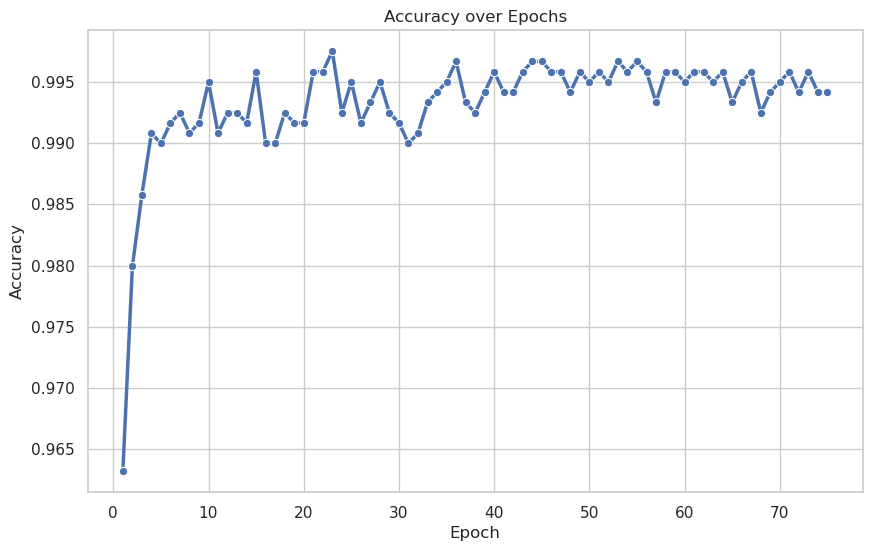

/tmp/ipykernel_747926/3376643326.py:79: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(x='Epoch', y='Accuracy', data=data_unseen, marker='o', palette="tab10", linewidth=2.5)


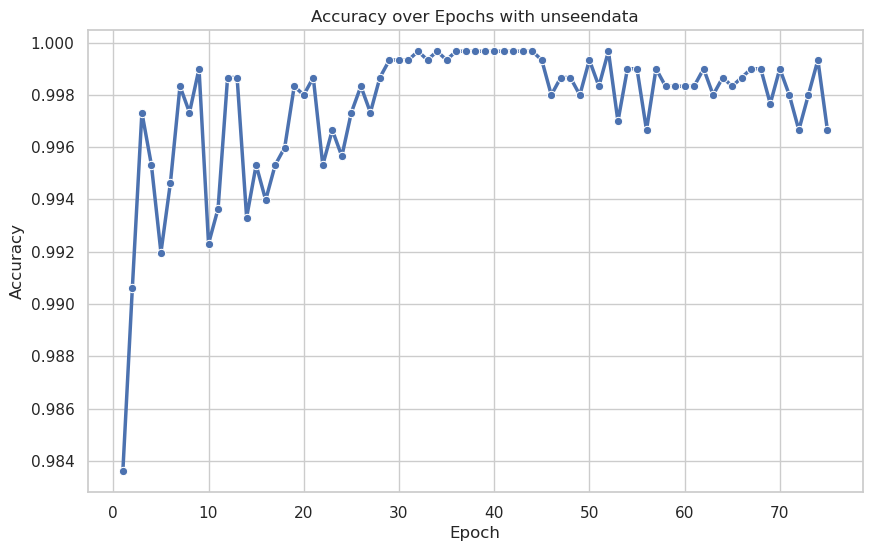

In [10]:
C = flattened_data.shape[1]
T = np.power((C/0.8377),1/2.2099)
s = 2.534*np.log((C/3.7579)) 

# Split your combined dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flattened_data, repeated_y_data, test_size=0.2)


training_steps = 75
epochs = 1
runs = 1 # Number of runs in total the Tsetlin Machine will do
for i in range(runs):
    epoch_accuracies = []
    epoch_unseen = []
    tm = MultiClassTsetlinMachine(int(C), T, s) # Init the Tsetlin Machine
    for epoch in range(training_steps):
        tm.fit(X_train, y_train, epochs=epochs, incremental=True)  # Train for epoch
        
        Y_pred = tm.predict(X_test)
    
        y_test = y_test.astype(Y_pred.dtype)
        
        #print(f"y_test dtype: {y_test.dtype}, Y_pred dtype: {Y_pred.dtype}")
        accuracy = accuracy_score(y_test, Y_pred)
        print(f'Epoch {epoch+1} Accuracy: {accuracy * 100:.2f}%')
        epoch_accuracies.append(accuracy)
        a_s = accuracy
    
        repeated_y_data_test = repeated_y_data_test.astype(Y_pred.dtype)
        Y_pred = tm.predict(flattened_data_test)
        accuracy = accuracy_score(repeated_y_data_test, Y_pred)
        print(f'Epoch {epoch+1} Accuracy for unseendata: {accuracy * 100:.2f}%')
        epoch_unseen.append(accuracy)
        a_u = accuracy
        
        accuracy_data = {
            "epoch_accuracies": epoch_accuracies,
            "epoch_unseen": epoch_unseen
        }

        try:
            with open(json_file, 'r') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            # Initialize with defaults if file doesn't exist or contains bad data
            data = {'training_run': [],}

        data['training_run'].append({
            'seendata': a_s,
            'unseendata': a_u,
        })
        
        with open(json_file, 'w') as f:
            json.dump(data, f, indent=4)
    

# Now you can plot the accuracy over epochs if you want
data = pd.DataFrame({
    'Epoch': range(1, training_steps + 1),
    'Accuracy': epoch_accuracies
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.lineplot(x='Epoch', y='Accuracy', data=data, marker='o', palette="tab10", linewidth=2.5)
plot.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy over Epochs')
#plt.savefig('../plot/accuracy_plot.png')  # Option for saving plot
plt.show()

data_unseen = pd.DataFrame({
    'Epoch': range(1, training_steps + 1),
    'Accuracy': epoch_unseen
})
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plot = sns.lineplot(x='Epoch', y='Accuracy', data=data_unseen, marker='o', palette="tab10", linewidth=2.5)
plot.set(xlabel='Epoch', ylabel='Accuracy', title='Accuracy over Epochs with unseendata')
#plt.savefig('../plot/accuracy_plot_unseen.png')  # Option for saving plot

plt.show()

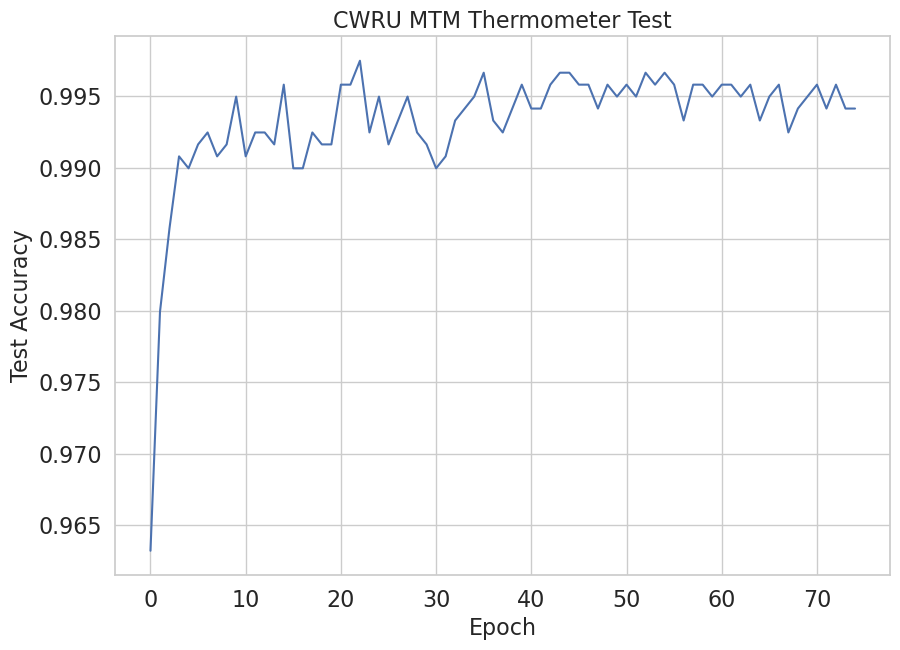

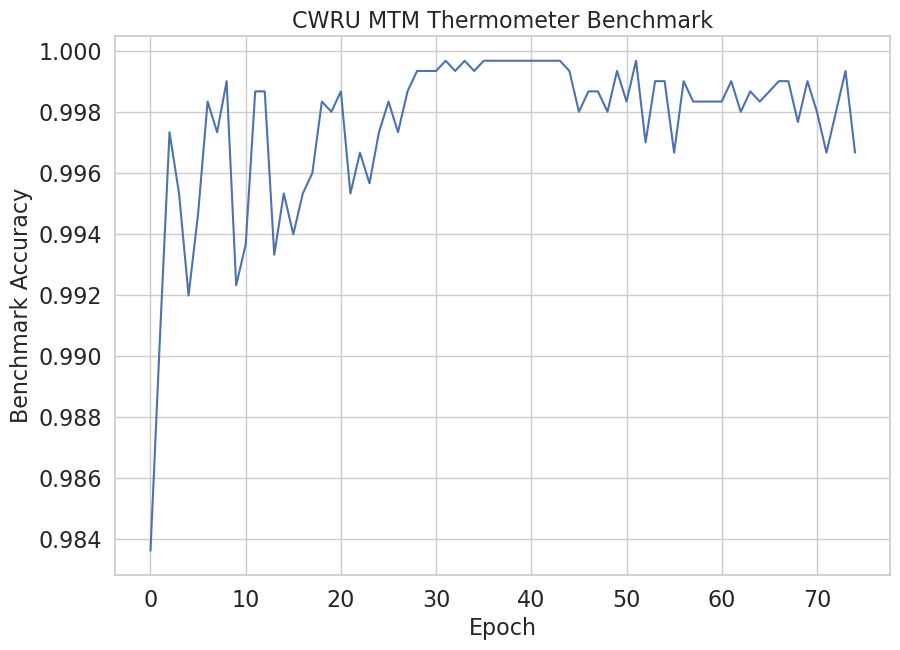

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_accuracies)
plt.title('CWRU MTM Thermometer Test',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Test Accuracy',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_CWRU_MTM_Thermometer_test.pdf') # Option for saving plot
plt.show()


plt.figure(figsize=(10, 7))
plt.plot(epoch_unseen)
plt.title('CWRU MTM Thermometer Benchmark',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Benchmark Accuracy',fontsize=16)
#plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.savefig('../plot/TM_CWRU_MTM_Thermometer_benchmark.pdf') # Option for saving plot
plt.show()


Confusion Matrix:
[[7962    1    5]
 [   0 7968    0]
 [   1    0 7967]]


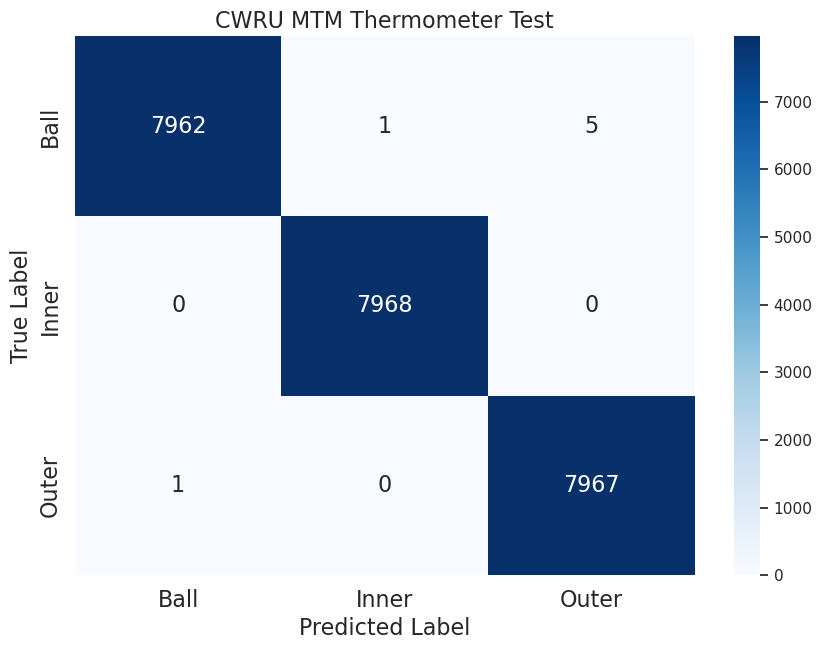

Confusion Matrix:
[[986  10   0]
 [  0 996   0]
 [  0   0 996]]


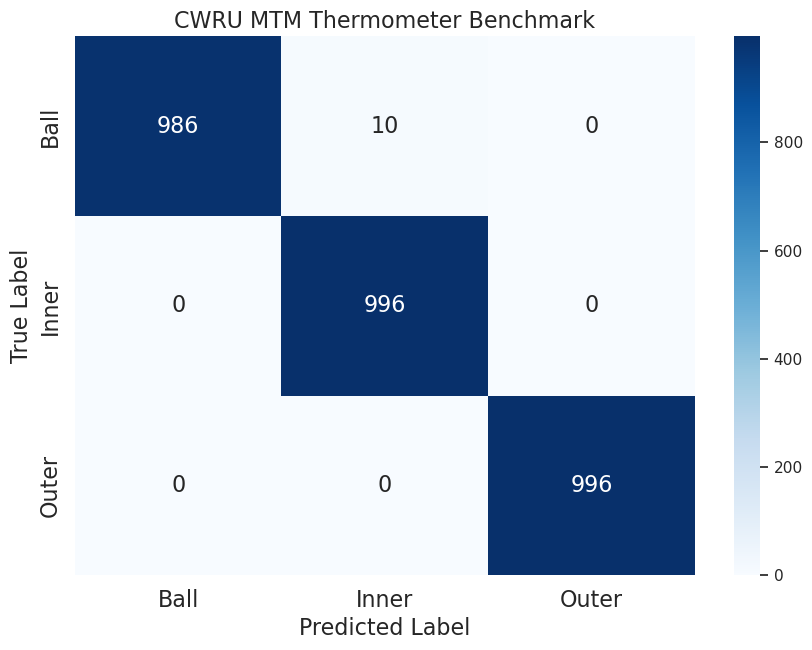

In [23]:
Y_pred = tm.predict(flattened_data)
repeated_y_data = repeated_y_data.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(repeated_y_data, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Define class labels (assuming they're the same as the ones used in NASA plot)
class_labels = ["Ball", "Inner", "Outer"]

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('CWRU MTM Thermometer Test', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0, fontsize=16)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90, fontsize=16)
# plt.savefig('../plot/CM_CWRU_MTM_Thermometer_test.pdf') # Option for saving plot
plt.show()


Y_pred = tm.predict(flattened_data_test)
repeated_y_data_test = repeated_y_data_test.astype(Y_pred.dtype)
conf_matrix = confusion_matrix(repeated_y_data_test, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Define class labels (assuming they're the same as the ones used in NASA plot)
class_labels = ["Ball", "Inner", "Outer"]

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title('CWRU MTM Thermometer Benchmark', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0, fontsize=16)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=90, fontsize=16)
# plt.savefig('../plot/CM_CWRU_MTM_Thermometer_benchmark.pdf') # Option for saving plot
plt.show()

In [19]:
print(C)
print(int(T))
print(s)

9800
69
19.933146865514093
